<a href="https://colab.research.google.com/github/hk-kiran/Covid-19-Detection/blob/master/Covid_19_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import math

In [38]:
INIT_LR = 1e-3
EPOCHS = 25
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest",
  validation_split=0.2,
  rescale=1. /255
  )

traindata = trainAug.flow_from_directory(
    "dataset",
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=1337,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset="training",
    interpolation="nearest",
)
print(traindata.class_indices)
print(traindata.n)
valdata = trainAug.flow_from_directory(
    "dataset",
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1337,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset="validation",
    interpolation="nearest",
)

Found 1774 images belonging to 2 classes.
{'covid': 0, 'normal': 1}
1774
Found 443 images belonging to 2 classes.


In [0]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False


In [26]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [28]:
print("[INFO] training head...")
H = model.fit(
	traindata,
	steps_per_epoch=math.ceil(traindata.n / traindata.batch_size),
	validation_data=valdata,
	validation_steps=math.ceil(valdata.n / valdata.batch_size),
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
14/14 [==============================] - 60s 4s/step - loss: 0.6257 - accuracy: 0.6691 - val_loss: 0.4328 - val_accuracy: 0.9165
Epoch 2/25
14/14 [==============================] - 61s 4s/step - loss: 0.3968 - accuracy: 0.8675 - val_loss: 0.3078 - val_accuracy: 0.9210
Epoch 3/25
14/14 [==============================] - 61s 4s/step - loss: 0.2844 - accuracy: 0.9222 - val_loss: 0.2320 - val_accuracy: 0.9436
Epoch 4/25
14/14 [==============================] - 61s 4s/step - loss: 0.2264 - accuracy: 0.9363 - val_loss: 0.1951 - val_accuracy: 0.9549
Epoch 5/25
14/14 [==============================] - 61s 4s/step - loss: 0.1910 - accuracy: 0.9476 - val_loss: 0.1665 - val_accuracy: 0.9481
Epoch 6/25
14/14 [==============================] - 61s 4s/step - loss: 0.1558 - accuracy: 0.9521 - val_loss: 0.1441 - val_accuracy: 0.9526
Epoch 7/25
14/14 [==============================] - 61s 4s/step - loss: 0.1421 - accuracy: 0.9566 - val_loss: 0.1270 - val_accuracy: 0.9

In [39]:
print("[INFO] evaluating network...")
#valdata.reset()
predIdxs = model.predict(valdata,
steps= math.ceil(valdata.n / valdata.batch_size),
verbose=1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
labels = (valdata.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(classification_report(valdata.labels, predIdxs,
	target_names=['covid','normal']))

[INFO] evaluating network...
4/4 [==============================] - 7s 2s/step
              precision    recall  f1-score   support

       covid       0.99      0.97      0.98       175
      normal       0.98      0.99      0.99       268

    accuracy                           0.98       443
   macro avg       0.98      0.98      0.98       443
weighted avg       0.98      0.98      0.98       443



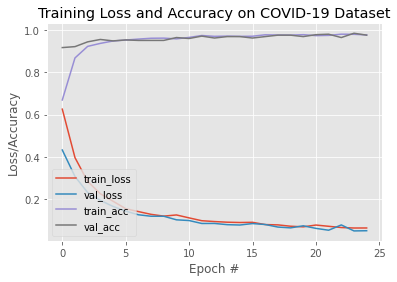

In [40]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
now = datetime.now()
dt_string = now.strftime("%d%m%Y%H:%M:%S")
plt.savefig("outputs/"+"plot.png")

In [43]:
valdata.labels
cm = confusion_matrix(valdata.labels, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[170   5]
 [  2 266]]
acc: 0.9842
sensitivity: 0.9714
specificity: 0.9925


In [34]:
print("[INFO] saving COVID-19 detector model...")
model.save("outputs/"+"covid19.model", save_format="h5")

[INFO] saving COVID-19 detector model...
